# 🌍 Seismic Imaging Course – 2025 Edition
### Numerical Modeling & Inversion (3/3)
**Professor:** Nicola Bienati

**Author:** Felipe Rincón  
*PhD Student in Geophysics*  
📧 felipe.rincon@phd.unipi.it  

/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_55708/4010684945.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


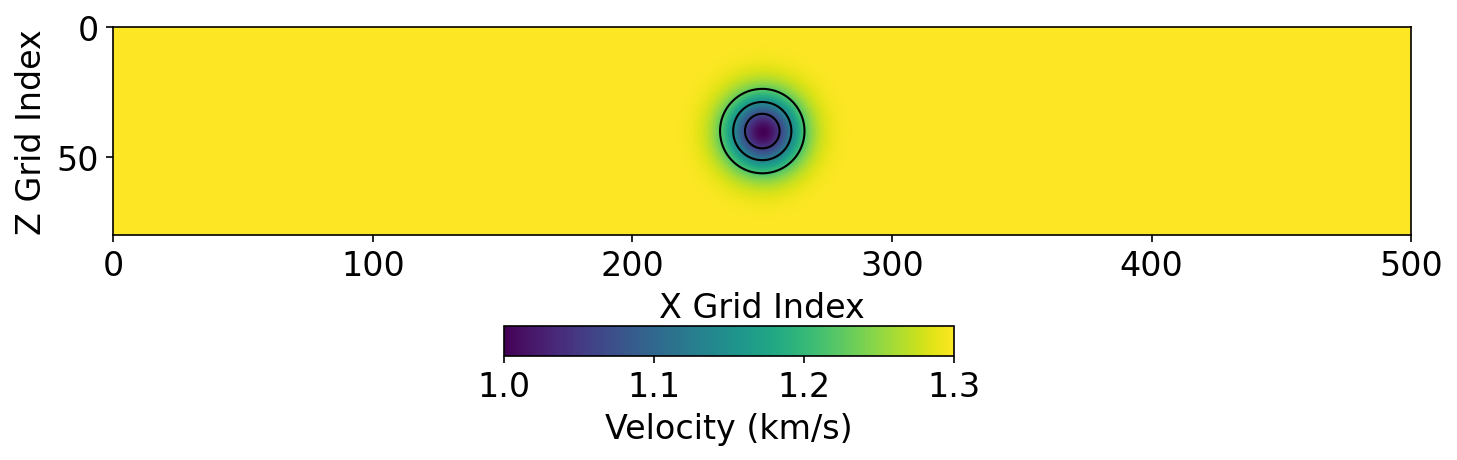

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seismic_utils import (
    generate_source_locations,
    generate_receiver_coordinates,
    plot_shotrecord_array,
    compute_residual,
    fwi_gradient,
    plot_velocity_clim,
    Model,
    configuration,
    AcquisitionGeometry,
    AcousticWaveSolver,
    mmax,
    compute_update
)

# Define model parameters
nx, nz = 500, 80
v0 = 1.3  # Background velocity
velocity = np.full((nz, nx), v0, dtype=float)

# Gaussian anomaly parameters
cx, cz = nx // 2, nz // 2  # Center of anomaly
sigma = 10                 # Controls spread of the Gaussian
perturbation = 0.3         # Amplitude of velocity reduction

# Generate coordinate grids
x = np.arange(nx)
z = np.arange(nz)
X, Z = np.meshgrid(x, z)

gaussian = perturbation * np.exp(-((X - cx)**2 + (Z - cz)**2) / (2 * sigma**2))
velocity -= gaussian

# Plotting
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(velocity, cmap="viridis", origin="lower", extent=[0, nx, 0, nz])
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Z Grid Index")

# Optional: overlay a contour to visualize the anomaly boundary
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

# Colorbar
cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
plt.show()

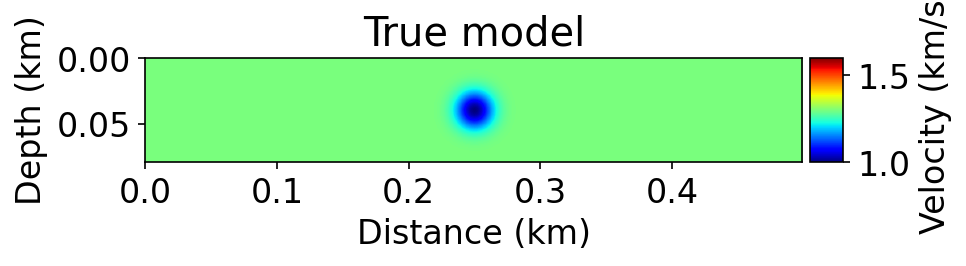

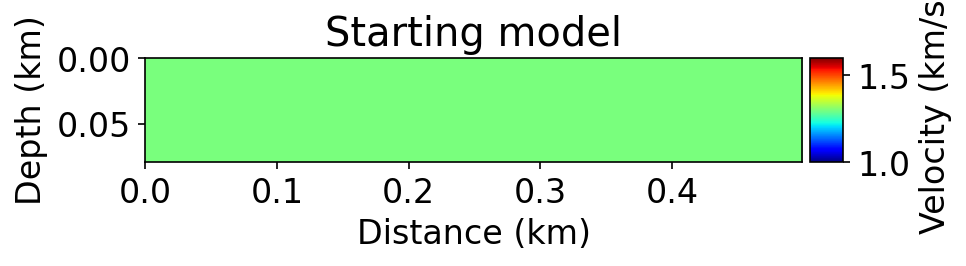

In [2]:
configuration['log-level'] = 'WARNING'
nshots = 10  # Number of shots
nreceivers = 300  # Number of receivers
fwi_iterations = 20  # Number of iterations

# Define true and initial model
shape = (500, 80)  # Number of grid point (nx, nz)
spacing = (1, 1) #in meters
origin = (0., 0.) 

v=np.transpose(velocity)
nbl=20
true_model = Model(vp=v, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0+perturbation, name="True model", cmap="jet")

#create an starting model
v2=np.ones(shape)*v0
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0+perturbation, name="Starting model", cmap="jet")

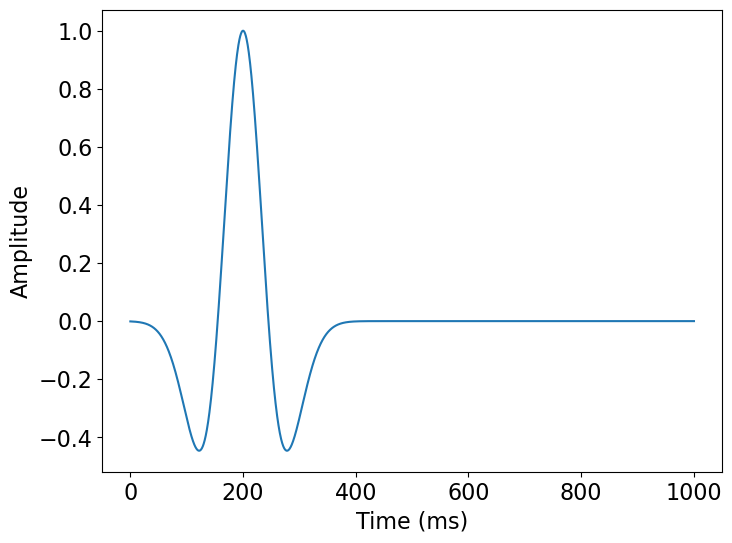

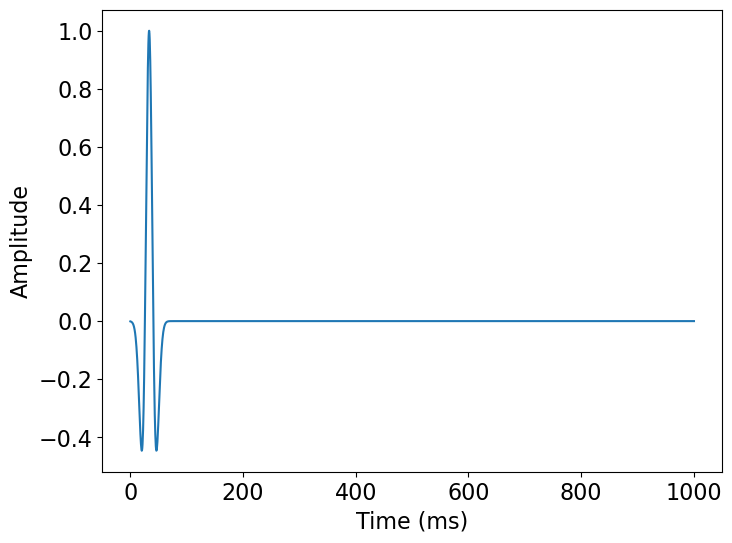

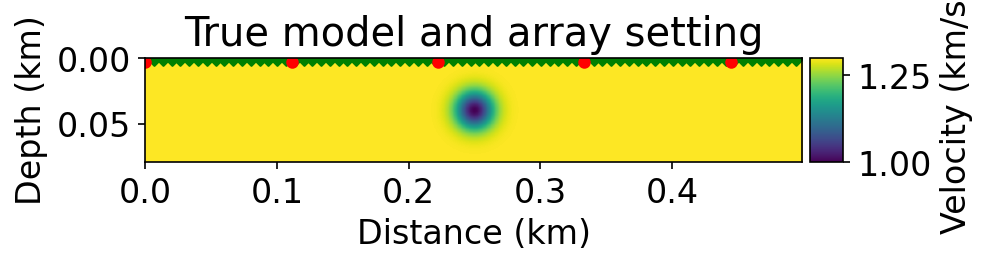

In [3]:
# Define acquisition geometry
t0 = 0
time = 1000.0
dt1 = 0.005 #KHz which means 5 Hz
dt2 = 0.03 #KHz which means 10 Hz

case_src=1
src_coordinates = generate_source_locations(case=case_src, nshots=10)

case_rcv=1
rec_coordinates = generate_receiver_coordinates(case=case_rcv, nreceivers=nreceivers, domain_size=true_model.domain_size)


geometry1 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt1, src_type='Ricker')
geometry1.src.show()

geometry2 = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates, t0, tn=time, f0=dt2, src_type='Ricker')
geometry2.src.show()

plot_velocity_clim(true_model,vmin=v0-perturbation, vmax=v0, name="True model and array setting", cmap="viridis", source=geometry1.src_positions,receiver=geometry1.rec_positions[::4, :])

In [4]:
# simulate the low and high frequency true and initial data
solver1 = AcousticWaveSolver(true_model, geometry1, space_order=4)
true_data1, _, _ = solver1.forward(vp=true_model.vp)
initial_data1, _, _ = solver1.forward(vp=start_model.vp)

solver2 = AcousticWaveSolver(true_model, geometry2, space_order=4)
true_data2, _, _ = solver2.forward(vp=true_model.vp)
initial_data2, _, _ = solver2.forward(vp=start_model.vp)

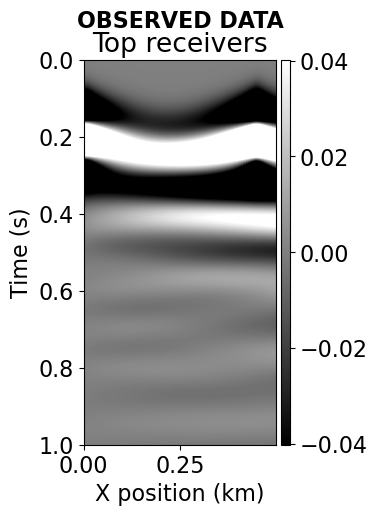

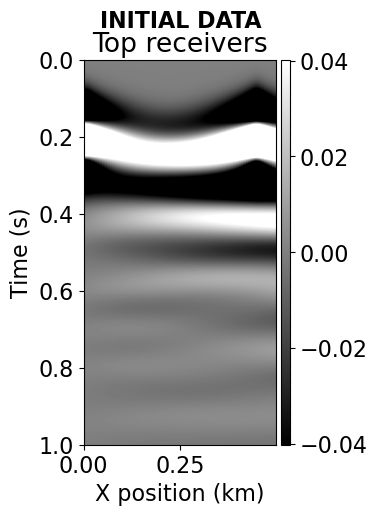

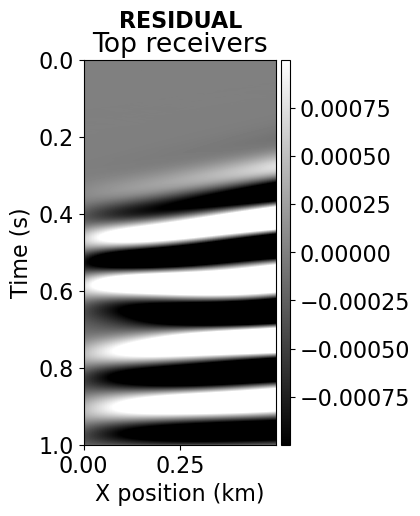

In [5]:
plot_shotrecord_array(true_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='OBSERVED DATA')
plot_shotrecord_array(initial_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='INITIAL DATA')
plot_shotrecord_array(initial_data1.data - true_data1.data, true_model, t0, time, case_rcv, colorbar=True,name='RESIDUAL')


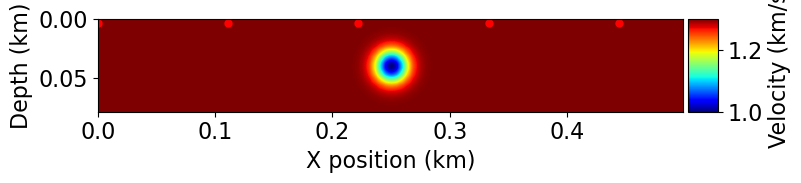

In [6]:
model=true_model

scale = np.max(true_data1.data) / 10.
extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
            1e-3*time, t0]

num_plots = len(str(case_rcv))
rows = 1
cols = num_plots

rec=true_data1.data

mult = len(str(case_src))
source_locations = generate_source_locations(case=case_src,nshots=nshots)

from examples.seismic import plot_velocity
plot_velocity(true_model, source=source_locations)


In [7]:
from devito import Min, Max, mmax
from devito import Operator, Eq

# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=0.8, vmax=1.3):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

# Run FWI with gradient descent
history1 = np.zeros((fwi_iterations, 1))
predicted_model1=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model
for i in range(0, fwi_iterations):
    phi1, direction1 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry1, #5 Hz
        nshots=nshots,
        source_locations=source_locations,
        solver=solver1, #5 Hz
        mult=mult
    )

    history1[i] = phi1
    alpha = .005 / mmax(direction1)
    update_with_box(temp_inv_mod.vp, alpha, direction1)
    predicted_model1[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective value is %.6f at iteration %d" % (phi1, i+1))

# Reset model for the 30 Hz inversion
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")

Objective value is 24.464653 at iteration 1
Objective value is 5.963041 at iteration 2
Objective value is 2.244586 at iteration 3
Objective value is 1.522213 at iteration 4
Objective value is 1.164542 at iteration 5
Objective value is 0.929149 at iteration 6
Objective value is 0.764358 at iteration 7
Objective value is 0.642057 at iteration 8
Objective value is 0.547924 at iteration 9
Objective value is 0.473658 at iteration 10
Objective value is 0.413951 at iteration 11
Objective value is 0.365008 at iteration 12
Objective value is 0.324251 at iteration 13
Objective value is 0.289911 at iteration 14
Objective value is 0.260694 at iteration 15
Objective value is 0.235666 at iteration 16
Objective value is 0.214041 at iteration 17
Objective value is 0.195246 at iteration 18
Objective value is 0.178804 at iteration 19
Objective value is 0.164357 at iteration 20


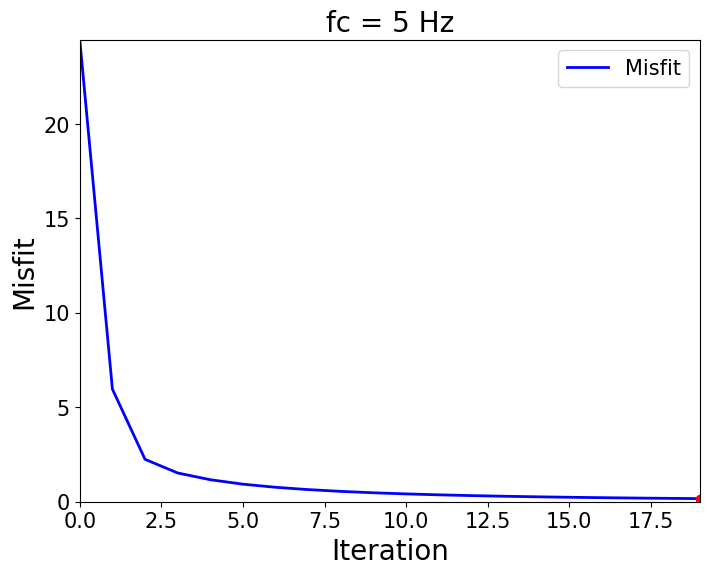

In [8]:
min_index = np.argmin(history1)
min_value = history1[min_index]

max_index = np.argmax(history1[:min_index+1])
max_value = history1[max_index]

plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])

plt.plot(history1, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('fc = 5 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_5hz.pdf", format='pdf', dpi=300)



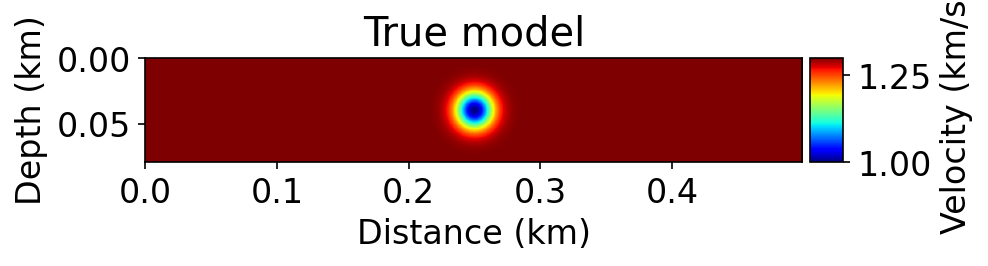

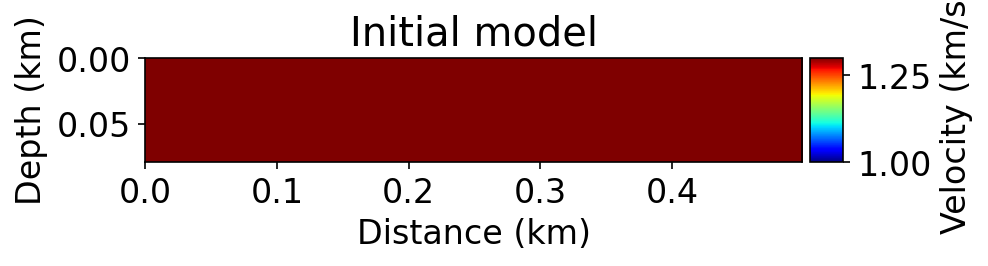

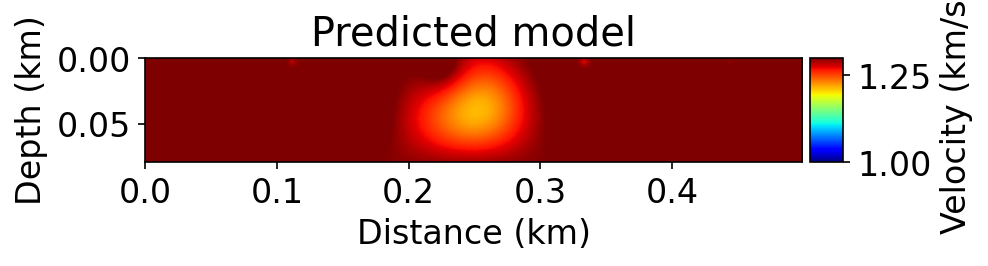

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0, name="True model", cmap="jet")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0, name="Initial model", cmap="jet")

pred_temp=(predicted_model1[:,:,min_index-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
pred_model = Model(vp=pred_temp, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(pred_model, vmin=v0-perturbation, vmax=v0, name="Predicted model", cmap="jet")


/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_55708/1194470736.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


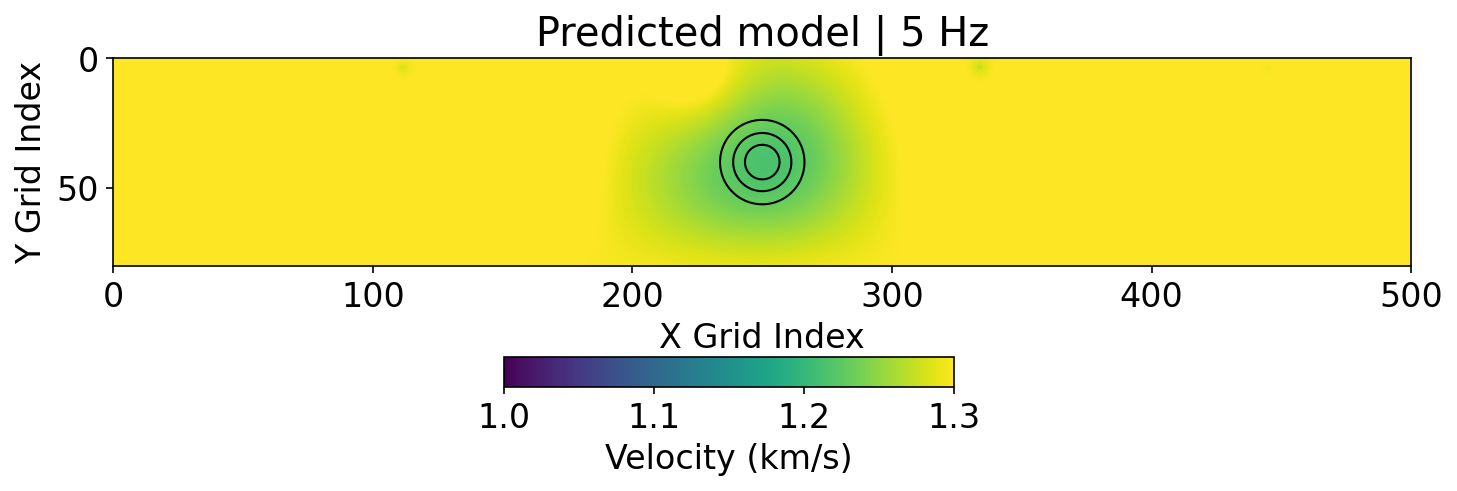

In [10]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 5 Hz")
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_5Hz.pdf", format='pdf', dpi=300)


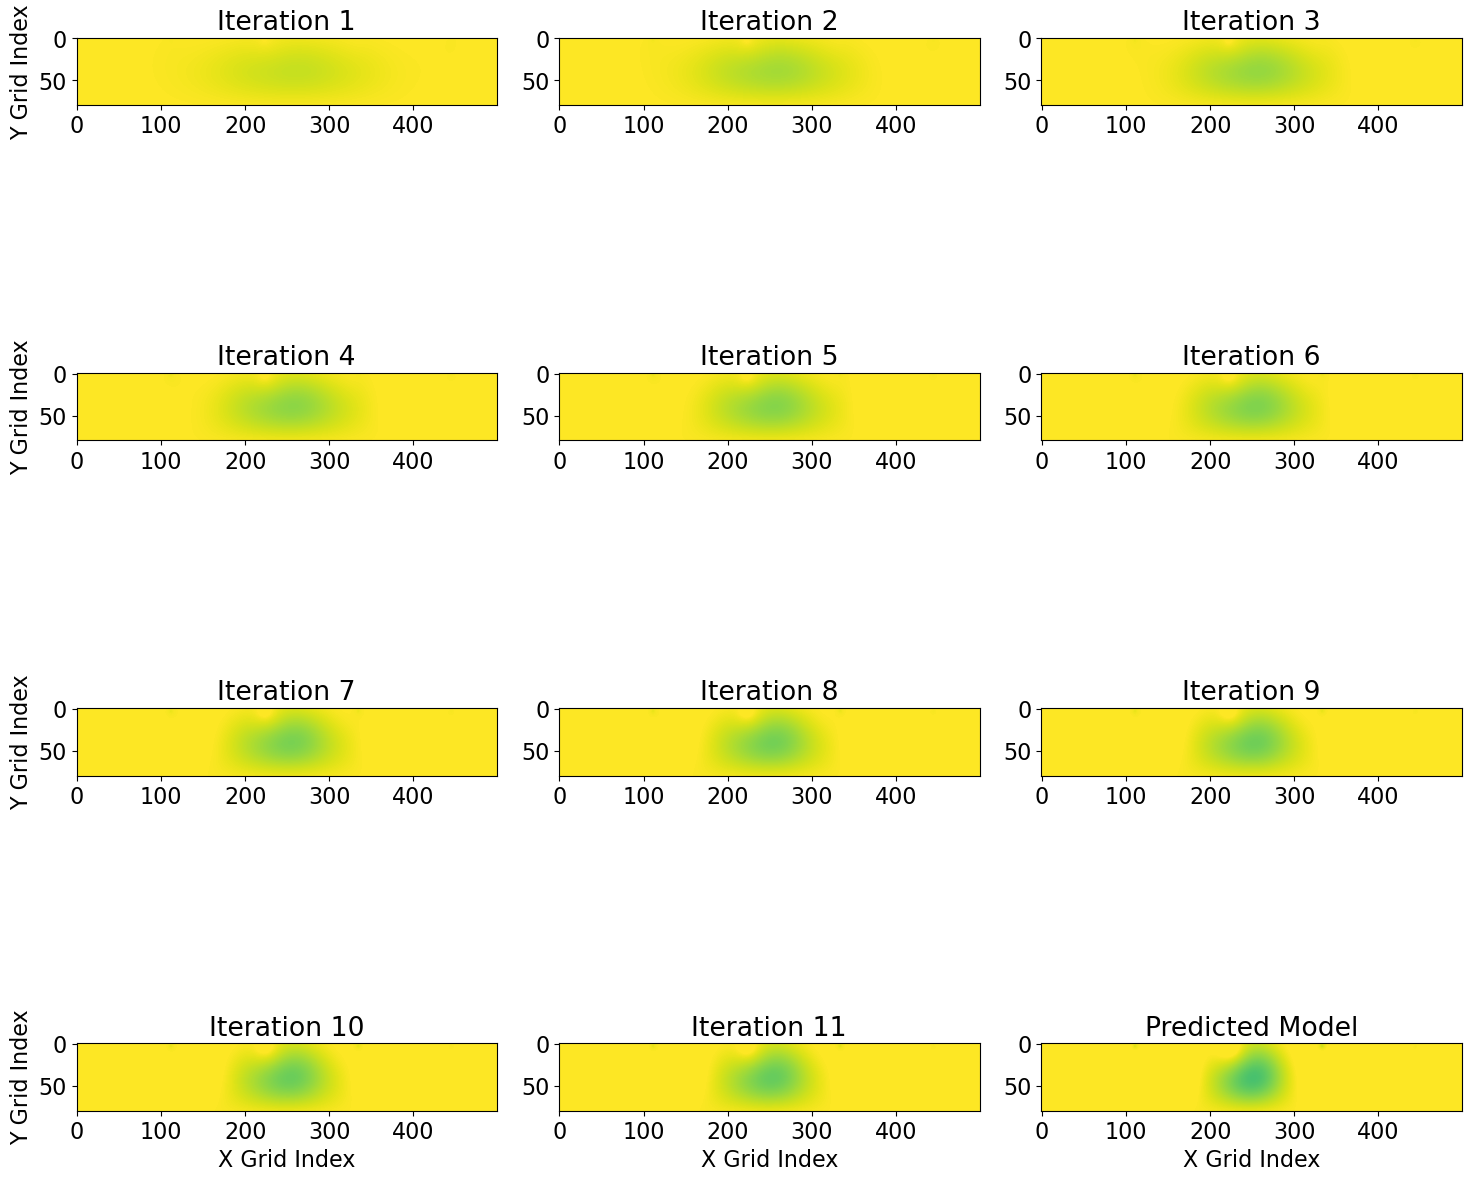

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
start_mod = start_model.vp.data[nbl:shape[0]+nbl, nbl:shape[1]+nbl]

im_starting = axes[0, 0].imshow(start_mod.T, cmap="jet", vmin=v0-perturbation, vmax=v0)
axes[0, 0].set_title('Starting Model')
axes[0, 0].set_ylabel('Y Grid Index') 

for i in range(4):
    for j in range(3):
        iteration = i * 3 + j
        if iteration <= fwi_iterations - 2: 
            pred_temp = predicted_model1[:, :, iteration]
            im = axes[i, j].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
            axes[i, j].set_title(f'Iteration {iteration+1}')
            if i == 3: 
                axes[i, j].set_xlabel('X Grid Index')
            if j == 0 and i != 0: 
                axes[i, j].set_ylabel('Y Grid Index')
        else:
            axes[i, j].axis('off')

if fwi_iterations - 2 >= 12: 
    pred_temp = predicted_model1[:, :, min_index - 1]
    im_predicted = axes[3, 2].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
    axes[3, 2].set_title('Predicted Model')
    axes[3, 2].set_xlabel('X Grid Index')

plt.tight_layout()
plt.show()

In [12]:
# Inverting for 30 Hz
fwi_iterations = 20
history2 = np.zeros((fwi_iterations, 1))
predicted_model2 = np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations))

start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model

for i in range(fwi_iterations):
    phi1, direction2 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry2,
        nshots=nshots,
        source_locations=source_locations,
        solver=solver2,
        mult=mult
    )

    history2[i] = phi1
    alpha = 0.005 / np.max(np.abs(direction2))
    update_with_box(temp_inv_mod.vp, alpha, direction2)
    predicted_model2[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective value is %.6f at iteration %d" % (phi1, i + 1))

    # --- Early stopping condition ---
    if i > 0 and phi1 > history2[i - 1]:
        print(f"\nStopping: Objective increased at iteration {i + 1}.")
        history2 = history2[:i]
        predicted_model2 = predicted_model2[:, :, :i]
        break

Objective value is 10.094023 at iteration 1
Objective value is 7.660516 at iteration 2
Objective value is 5.916078 at iteration 3
Objective value is 5.304732 at iteration 4
Objective value is 4.387976 at iteration 5
Objective value is 3.971876 at iteration 6
Objective value is 3.399694 at iteration 7
Objective value is 3.270895 at iteration 8
Objective value is 2.815443 at iteration 9
Objective value is 2.726708 at iteration 10
Objective value is 2.375908 at iteration 11
Objective value is 2.468465 at iteration 12

Stopping: Objective increased at iteration 12.


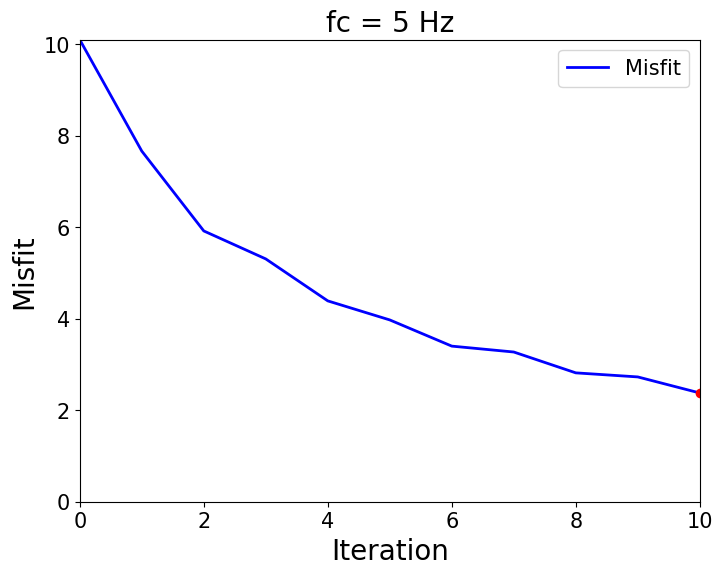

In [13]:
min_index = np.argmin(history2)
min_value = history2[min_index]

max_index = np.argmax(history2[:min_index+1])
max_value = history2[max_index]


plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])

plt.plot(history2, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('fc = 5 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_30hz.pdf", format='pdf', dpi=300)

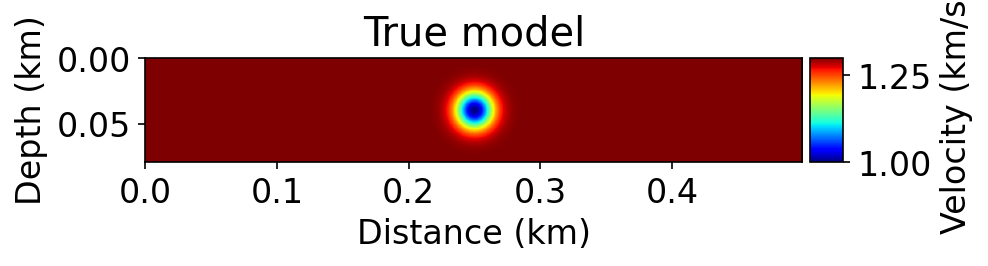

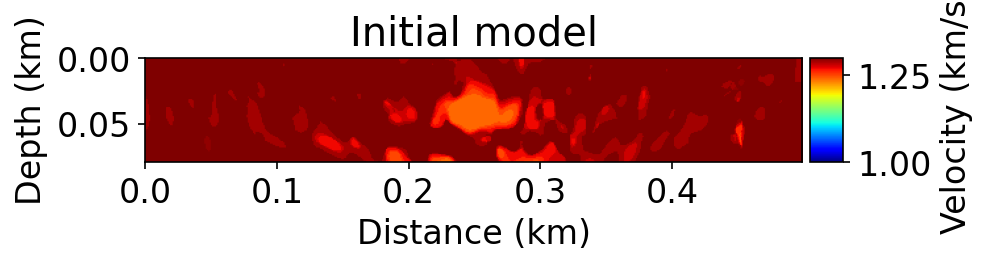

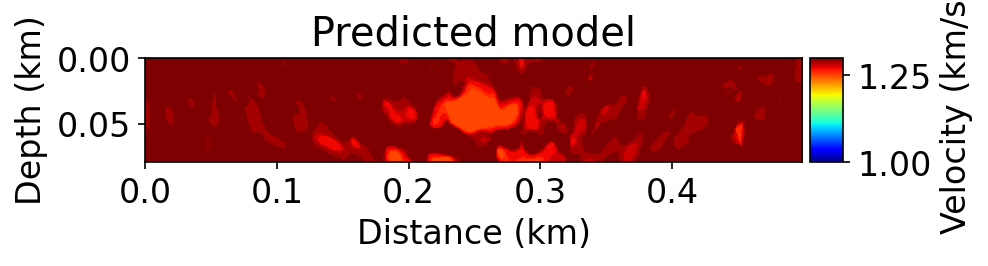

In [14]:
plot_velocity_clim(true_model, vmin=v0-perturbation, vmax=v0, name="True model", cmap="jet")
plot_velocity_clim(start_model, vmin=v0-perturbation, vmax=v0, name="Initial model", cmap="jet")

pred_temp=(predicted_model2[:,:,min_index-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
pred_model = Model(vp=pred_temp, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
plot_velocity_clim(pred_model, vmin=v0-perturbation, vmax=v0, name="Predicted model", cmap="jet")


/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_55708/4293740204.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


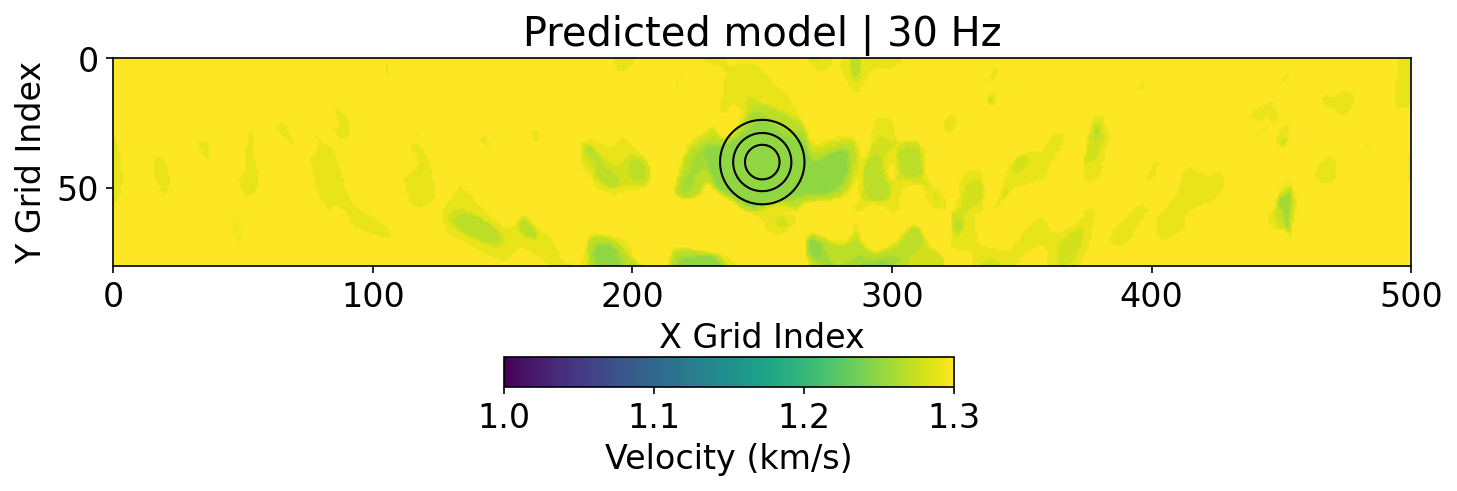

In [15]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 30 Hz")
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_30Hz.pdf", format='pdf', dpi=300)


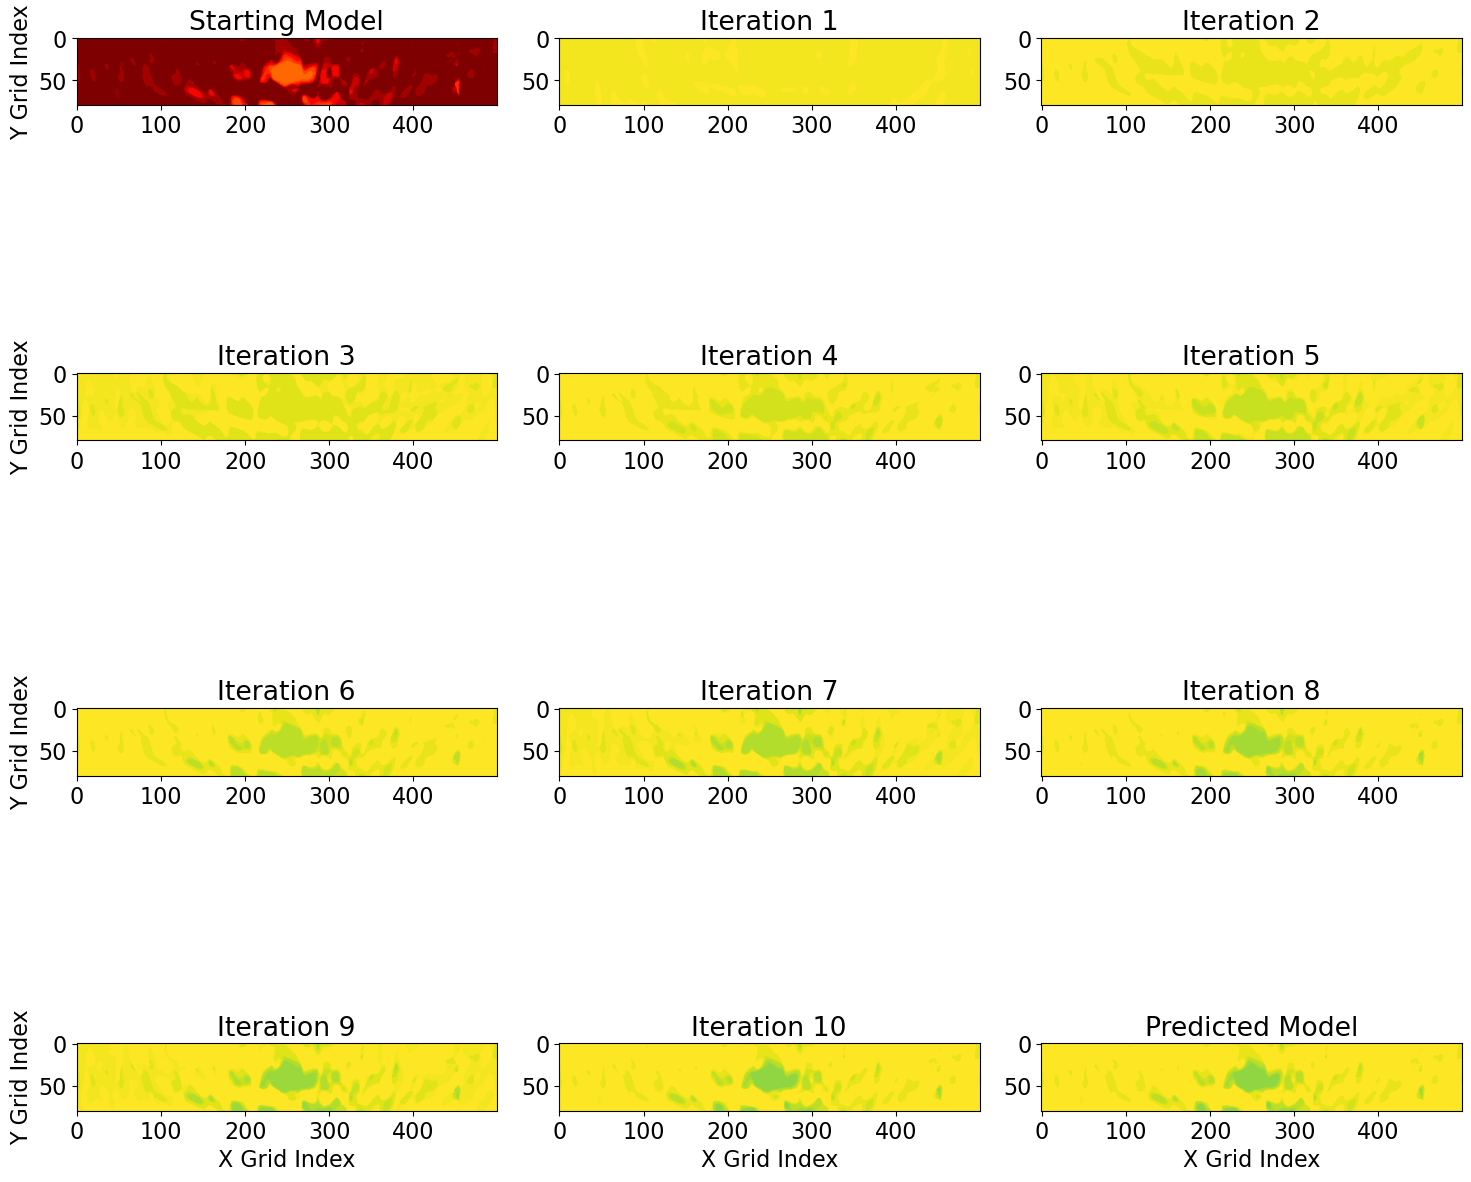

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
start_mod = start_model.vp.data[nbl:shape[0]+nbl, nbl:shape[1]+nbl]
axes[0, 0].imshow(start_mod.T, cmap="jet", vmin=v0-perturbation, vmax=v0)
axes[0, 0].set_title('Starting Model')
axes[0, 0].set_ylabel('Y Grid Index')

num_iters = predicted_model2.shape[2]

for i in range(4):
    for j in range(3):
        iteration = i * 3 + j
        if iteration == 0:
            continue
        elif iteration - 1 < num_iters:
            pred_temp = predicted_model2[:, :, iteration - 1]
            axes[i, j].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
            axes[i, j].set_title(f'Iteration {iteration}')
            if i == 3: 
                axes[i, j].set_xlabel('X Grid Index')
            if j == 0: 
                axes[i, j].set_ylabel('Y Grid Index')
        else:
            axes[i, j].axis('off')

if 'min_index' in locals() and min_index - 1 < num_iters:
    pred_temp = predicted_model2[:, :, min_index - 1]
    axes[3, 2].imshow(pred_temp[nbl:shape[0]+nbl, nbl:shape[1]+nbl].T, cmap="viridis", vmin=v0-perturbation, vmax=v0)
    axes[3, 2].set_title('Predicted Model')
    axes[3, 2].set_xlabel('X Grid Index')

plt.tight_layout()
plt.show()

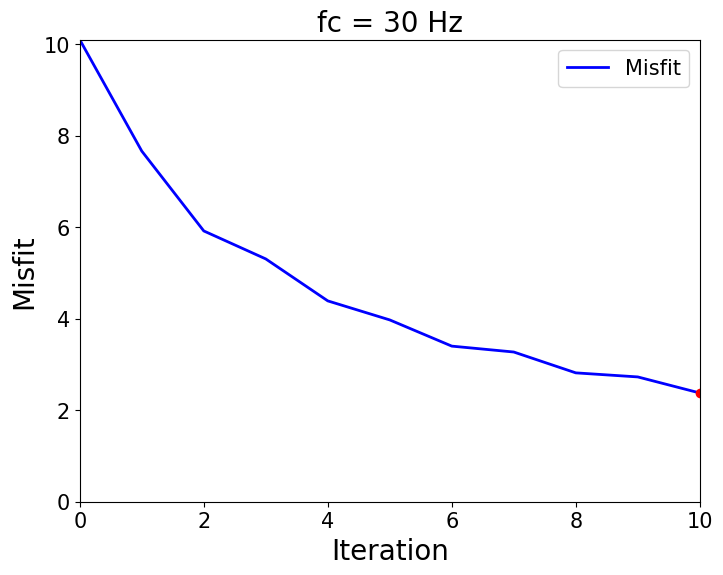

In [17]:
min_index = np.argmin(history2)
min_value = history2[min_index]

max_index = np.argmax(history2[:min_index+1])
max_value = history2[max_index]


plt.figure(figsize=(8, 6))
plt.xlim([0, min_index])
plt.ylim([0, max_value])

plt.plot(history2, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('fc = 30 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_30hz.pdf", format='pdf', dpi=300)



In [22]:
#TWO STEPS MULTI SCALE

# Run FWI @5Hz
fwi_iterations1=20
fwi_iterations2=40

history1 = np.zeros((fwi_iterations1+fwi_iterations2, 1))
predicted_model1=np.zeros(((shape[0]+2*nbl), (shape[1]+2*nbl), fwi_iterations1+fwi_iterations2))
start_model = Model(vp=v2, origin=origin, shape=shape, spacing=spacing, nbl=nbl, space_order=2, bcs="damp")
temp_inv_mod = start_model

for i in range(0, fwi_iterations1):
    phi1, direction1 = fwi_gradient(
        vp_in=temp_inv_mod.vp,
        true_model=true_model,
        geometry=geometry1, #5 Hz
        nshots=nshots,
        source_locations=source_locations,
        solver=solver1, #5 Hz
        mult=mult
    )

    history1[i] = phi1
    alpha = .005 / mmax(direction1)
    update_with_box(temp_inv_mod.vp, alpha, direction1)
    predicted_model1[:, :, i] = np.asarray(temp_inv_mod.vp.data)
    print("Objective function @ 5Hz is %.6f at iteration %d" % (phi1, i+1))

Objective function @ 5Hz is 24.464653 at iteration 1
Objective function @ 5Hz is 5.963041 at iteration 2
Objective function @ 5Hz is 2.244586 at iteration 3
Objective function @ 5Hz is 1.522213 at iteration 4
Objective function @ 5Hz is 1.164542 at iteration 5
Objective function @ 5Hz is 0.929149 at iteration 6
Objective function @ 5Hz is 0.764358 at iteration 7
Objective function @ 5Hz is 0.642057 at iteration 8
Objective function @ 5Hz is 0.547924 at iteration 9
Objective function @ 5Hz is 0.473658 at iteration 10
Objective function @ 5Hz is 0.413951 at iteration 11
Objective function @ 5Hz is 0.365008 at iteration 12
Objective function @ 5Hz is 0.324251 at iteration 13
Objective function @ 5Hz is 0.289911 at iteration 14
Objective function @ 5Hz is 0.260694 at iteration 15
Objective function @ 5Hz is 0.235666 at iteration 16
Objective function @ 5Hz is 0.214041 at iteration 17
Objective function @ 5Hz is 0.195246 at iteration 18
Objective function @ 5Hz is 0.178804 at iteration 19
O

In [23]:
model=true_model
scale = np.max(true_data2.data) / 10.
extent = [model.origin[0], model.origin[0] + 1e-3*model.domain_size[0],
            1e-3*time, t0]

num_plots = len(str(case_rcv))
rows = 1
cols = num_plots

rec=true_data2.data
mult = len(str(case_src))

#compute the gradient
ff, update = fwi_gradient(vp_in=temp_inv_mod.vp, true_model=true_model, geometry=geometry2, nshots=nshots,source_locations=source_locations,solver=solver2, mult=mult)
a=-update.data[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
b2=(true_model.vp.data-start_model.vp.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]
alpha = .5 / mmax(update)
c2=(start_model.vp.data + alpha*update.data)[nbl:shape[0]+nbl,nbl:shape[1]+nbl]


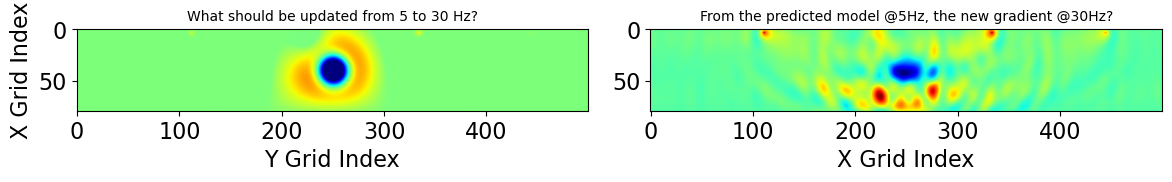

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
im1 = axes[0].imshow(np.transpose(b2), vmin=-0.1, vmax=0.1, cmap="jet")
# axes[0].set_title('What should be updated?')
axes[0].set_title('What should be updated from 5 to 30 Hz?', fontsize=10)
axes[0].set_xlabel('Y Grid Index')
axes[0].set_ylabel('X Grid Index')
im2 = axes[1].imshow(np.transpose(c2), cmap="jet")
axes[1].set_title('From the predicted model @5Hz, the new gradient @30Hz?', fontsize=10)
axes[1].set_xlabel('X Grid Index')
plt.tight_layout()
# plt.savefig("grad_@5_30hz.pdf", format='pdf', dpi=300)
plt.show()

In [25]:
# Run FWI @30Hz
start_model30Hz = temp_inv_mod
previous_phi = None
for i in range(fwi_iterations2):
    phi2, direction2 = fwi_gradient(
        vp_in=start_model30Hz.vp,
        true_model=true_model,
        geometry=geometry2,
        nshots=nshots,
        source_locations=source_locations,
        solver=solver2,
        mult=mult
    )

    if previous_phi is not None and phi2 > previous_phi:
        print(f"Stopping early at iteration {i} (phi increased: {phi2:.6f} > {previous_phi:.6f})")
        break

    history1[fwi_iterations1 + i] = phi2
    alpha = 0.005 / mmax(direction2) #with an smaller alpha scaling factor?
    update_with_box(start_model30Hz.vp, alpha, direction2)
    predicted_model1[:, :, fwi_iterations1 + i] = np.asarray(start_model30Hz.vp.data)
    print("Objective @ 30Hz is %.6f at iteration %d" % (phi2, fwi_iterations1 + i + 1))

    previous_phi = phi2

Objective @ 30Hz is 5.158294 at iteration 21
Objective @ 30Hz is 4.670829 at iteration 22
Objective @ 30Hz is 4.232400 at iteration 23
Objective @ 30Hz is 3.835849 at iteration 24
Objective @ 30Hz is 3.474627 at iteration 25
Objective @ 30Hz is 3.142665 at iteration 26
Objective @ 30Hz is 2.836599 at iteration 27
Objective @ 30Hz is 2.557549 at iteration 28
Objective @ 30Hz is 2.310548 at iteration 29
Objective @ 30Hz is 2.090858 at iteration 30
Objective @ 30Hz is 1.893984 at iteration 31
Objective @ 30Hz is 1.715613 at iteration 32
Objective @ 30Hz is 1.553634 at iteration 33
Objective @ 30Hz is 1.406231 at iteration 34
Objective @ 30Hz is 1.271667 at iteration 35
Objective @ 30Hz is 1.148870 at iteration 36
Objective @ 30Hz is 1.036418 at iteration 37
Objective @ 30Hz is 0.933137 at iteration 38
Objective @ 30Hz is 0.838378 at iteration 39
Objective @ 30Hz is 0.751284 at iteration 40
Objective @ 30Hz is 0.670973 at iteration 41
Objective @ 30Hz is 0.597122 at iteration 42
Objective 

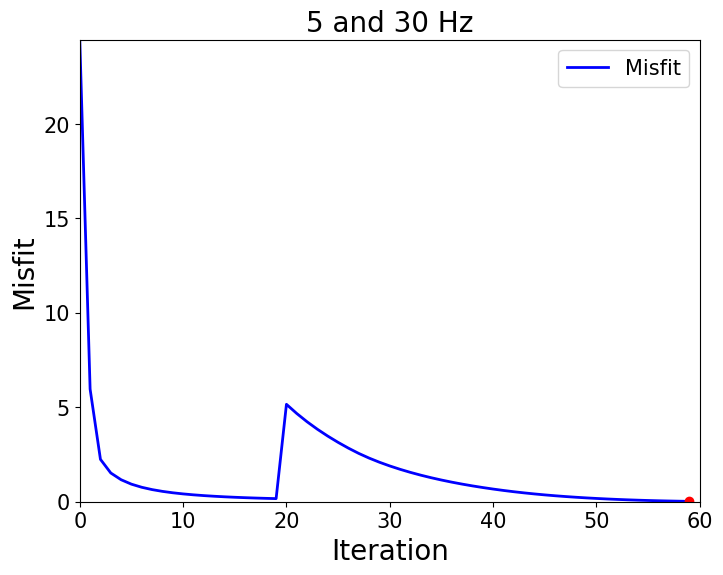

In [26]:
min_index = np.argmin(history1)
min_value = history1[min_index]

max_index = np.argmax(history1[:min_index+1])
max_value = history1[max_index]


plt.figure(figsize=(8, 6))
plt.xlim([0, fwi_iterations1+fwi_iterations2])
plt.ylim([0, max_value])

plt.plot(history1, color='b', linewidth=2, label='Misfit')
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Misfit', fontsize=20)
plt.title('5 and 30 Hz', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.plot(min_index, min_value, 'ro')
# plt.savefig("error_5and30hz.pdf", format='pdf', dpi=300)


/var/folders/s2/qbbddkw9511125_hf1dl0zd40000gn/T/ipykernel_55708/3552556473.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


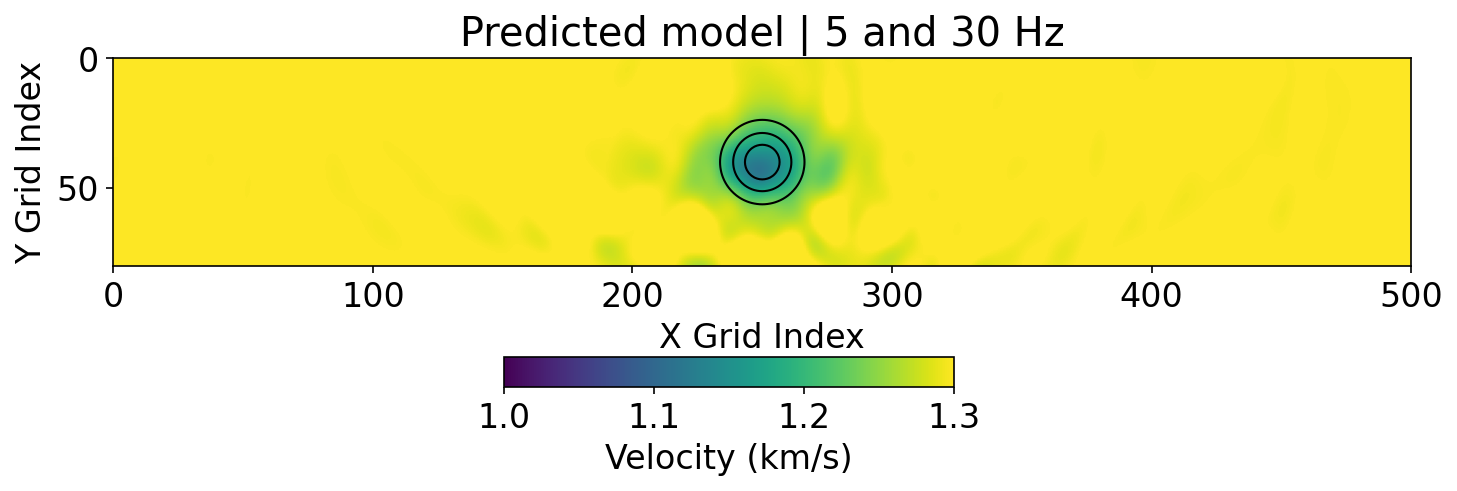

In [29]:
fig = plt.figure(figsize=(10, 4), dpi=150)
ax = fig.add_subplot(111)
pred_temp=(predicted_model1[:,:,40-1])
pred_temp=(pred_temp[nbl:(shape[0]+2*nbl)-nbl,nbl:(shape[1]+2*nbl)-nbl])
im = ax.imshow(np.transpose(pred_temp), cmap="viridis", origin="lower", extent=[0, nx, 0, nz],vmin=v0-perturbation, vmax=v0)
ax.invert_yaxis()
ax.set_xlabel("X Grid Index")
ax.set_ylabel("Y Grid Index")
ax.set_title("Predicted model | 5 and 30 Hz")
cs = ax.contour(X, Z, gaussian, levels=3, colors='black', linewidths=1)

cbar_ax = fig.add_axes([0.35, 0.2, 0.3, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label("Velocity (km/s)")
plt.tight_layout(rect=[0, 0.15, 1, 1])
# plt.savefig("pred_mod_5_and_30Hz.pdf", format='pdf', dpi=300)
